# <h1 style="color:turquoise;">Deliverable3: Clasificación con CNN</h1>

## Dependencias

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import random
import os

from sklearn.metrics import confusion_matrix, classification_report

from keras.applications.inception_v3 import InceptionV3
from keras.metrics import Precision, Recall
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD

## Dataset

El conjunto de datos que vamos a emplear para desarrolllar esta práctica consta de 26.0000 imágenes de animales (de diferente diemensión) agrupados en 10 categorías: perro, gato, caballo, mariposa, araña, pollo, oveja, vaca, ardilla y elefante.

El directorio principal está dividido en carpetas, una para cada categoría. El recuento de imágenes para cada categoría varía de 2K a 5K unidades.

https://www.kaggle.com/datasets/alessiocorrado99/animals10

Recordemos que para el desarrollo de esta práctica tenemos que seleccionar 5 de las 10 categorías. 


## ETL

En este bloque procesaremos nuestro dataset con el fin de crear un conjunto de entrenamiento y test para posteriormente entrenar nuestro modelo.

Primero establecemos el *path* de nuestro dataset y renombramos las carpetas pasando de italiano a inglés, por comodidad.

In [10]:
path = '.\\dataset\\raw-img'

translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "dog": "cane", "elephant": "elefante", "butterfly": "farfalla",
    "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

for folder_name in os.listdir(path):
    folder_path = os.path.join(path, folder_name)
    if os.path.isdir(folder_path):
        english_name = translate.get(folder_name, folder_name)
        if english_name != folder_name:
            new_folder_path = os.path.join(path, english_name)
            os.rename(folder_path, new_folder_path)

Definimos algunas variables que vamos a necesitar posteriormente. Establecemos la lista con las clases que queremos emplear en nuestro proyecto.

In [2]:
original_dataset_path = '.\\dataset\\raw-img'
new_dataset_path = '.\\new_dataset'
NUM_CLASSES = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH) 
selected_classes = ['cat','ragno','butterfly','elephant','chicken']
colors = ['blue', 'green', 'red', 'purple', 'orange']
print(f"Las 5 clases seleccionadas son: {selected_classes}")

Las 5 clases seleccionadas son: ['cat', 'ragno', 'butterfly', 'elephant', 'chicken']


Vamos a generar un nuevo dataset que va a contener la información de las imágenes reescaladas en función de `IMAGE_SIZE`

In [ ]:
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

all_classes = os.listdir(original_dataset_path)

# Para cada clase creamos un nuevo subdirectorio dentro del nuevo directorio padre new_dataset
for class_name in selected_classes:
    class_path = os.path.join(new_dataset_path, class_name)
    if not os.path.exists(class_path):
        os.makedirs(class_path)

    class_source_path = os.path.join(original_dataset_path, class_name)
    images = os.listdir(class_source_path)

    for image_name in images:
        image_path = os.path.join(class_source_path, image_name)
        with Image.open(image_path) as img:
            img_resized = img.resize(IMAGE_SIZE)
            img_resized.save(os.path.join(class_path, image_name))

Las 5 clases seleccionadas son: ['cat', 'ragno', 'butterfly', 'elephant', 'chicken']


Representemos algunas imágenes de nuestro dataset

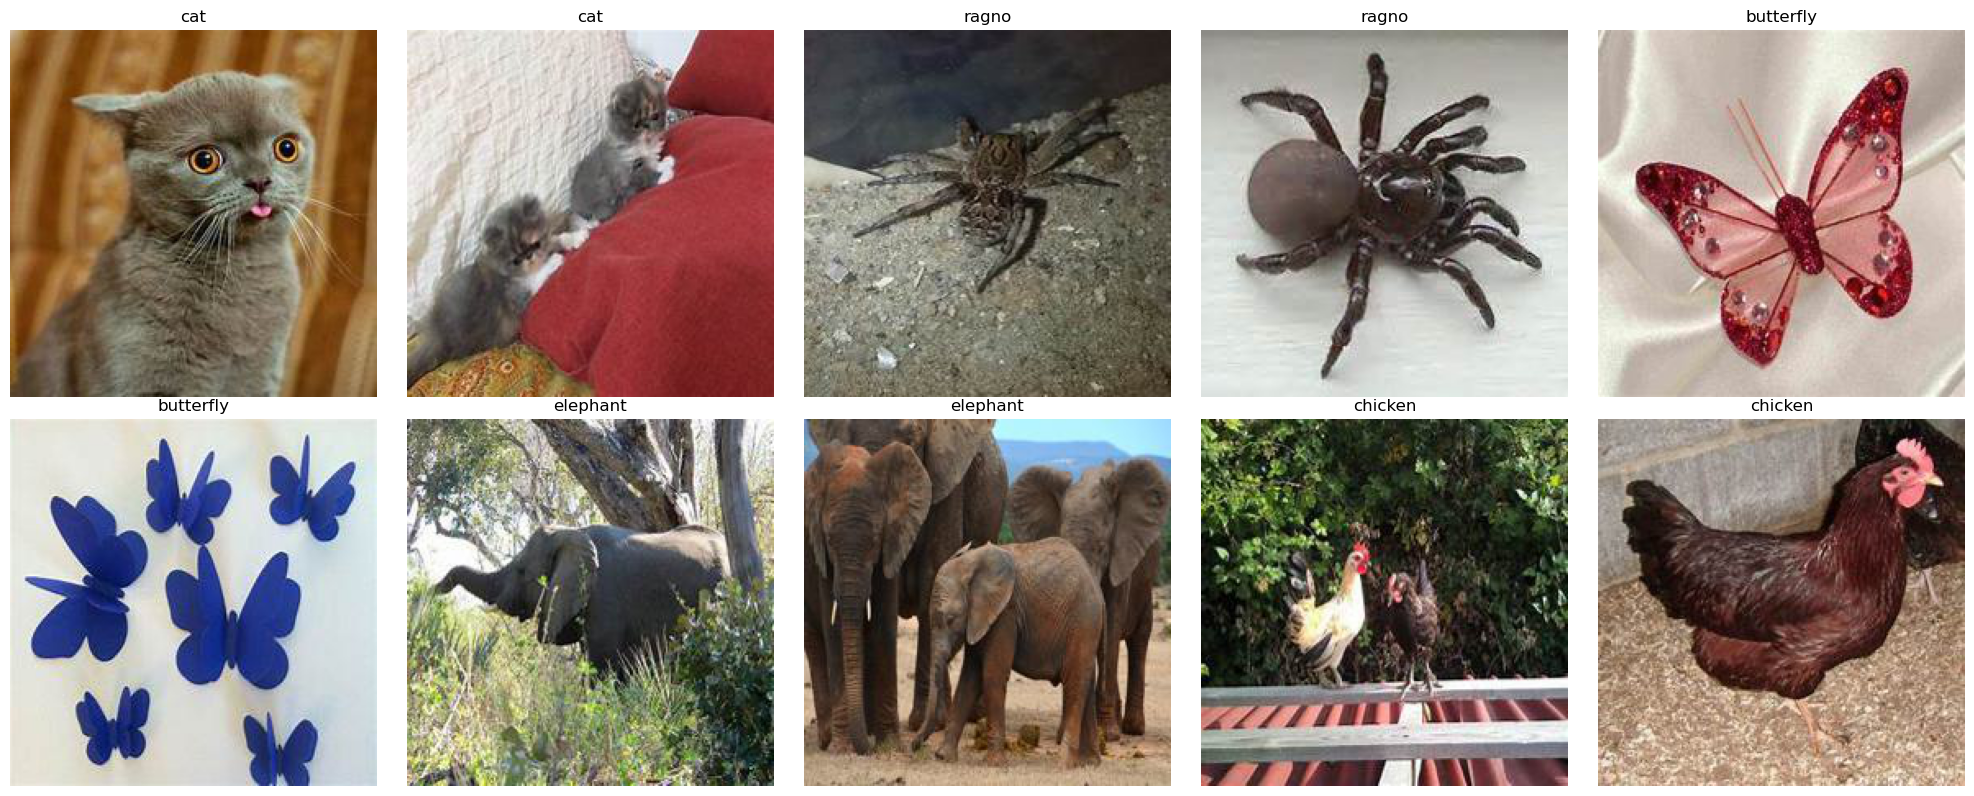

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

images_per_class = 2
selected_images = []

for class_name in selected_classes:
    class_path = os.path.join(new_dataset_path, class_name)
    image_names = random.sample(os.listdir(class_path), images_per_class)
    for image_name in image_names:
        selected_images.append((class_name, os.path.join(class_path, image_name)))

for ax, (class_name, image_path) in zip(axes, selected_images):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

En el siguiente bloque se definen los generadores de imágenes, conjunto de entrenamiento y test. El generador de imágenes se va a encargar de escalar las imágenes, aplicar una *data augmentation* (este solamente aplica sobre el conjunto de entrenamiento) y definir el tamaño del split. 

In [11]:
BATCH_SIZE = 15
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1/255., 
    horizontal_flip=True,  
    validation_split=0.2  
)

val_datagen = ImageDataGenerator(
    rescale=1/255.,  
    validation_split=0.2 
)

train_ds = train_datagen.flow_from_directory(
    directory = new_dataset_path,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    class_mode='categorical',
    subset='training',
)

val_ds = val_datagen.flow_from_directory(
    directory = new_dataset_path,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    class_mode='categorical',
    subset='validation',
)

Found 10518 images belonging to 5 classes.
Found 2627 images belonging to 5 classes.


Una primera visual de nuestro conjunto de entrenamiento y validación:

In [12]:
train_class_counts = np.zeros(5)
for label in train_ds.classes:
    train_class_counts[label] += 1

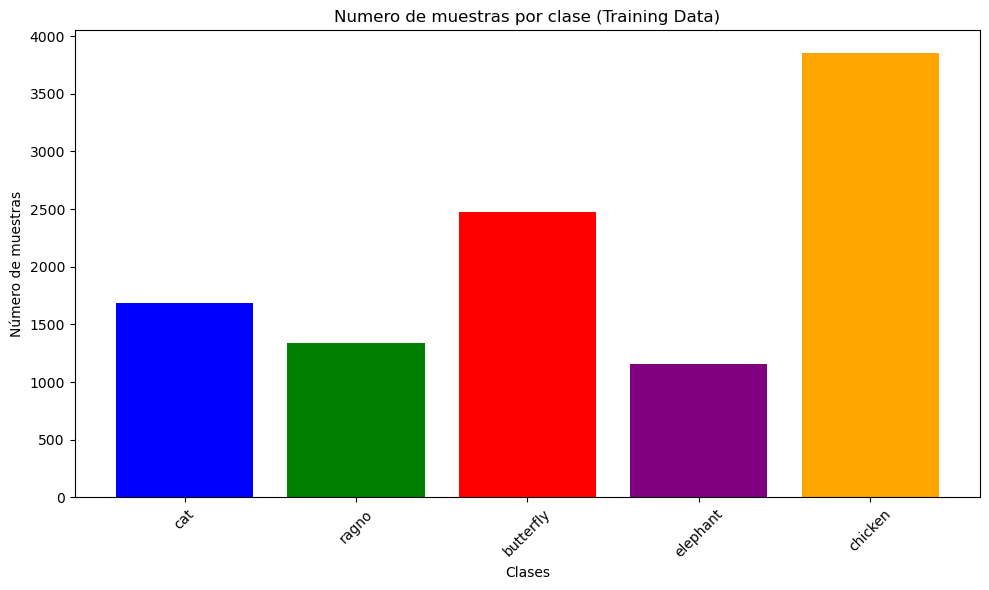

In [13]:
x = np.arange(5)

plt.figure(figsize=(10, 6))
plt.bar(x, train_class_counts,color=colors)

plt.xticks(x, selected_classes, rotation=45)
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.title("Numero de muestras por clase (Training Data)")
plt.tight_layout()
plt.show()

In [14]:
val_class_counts = np.zeros(5)
for label in val_ds.classes:
    val_class_counts[label] += 1

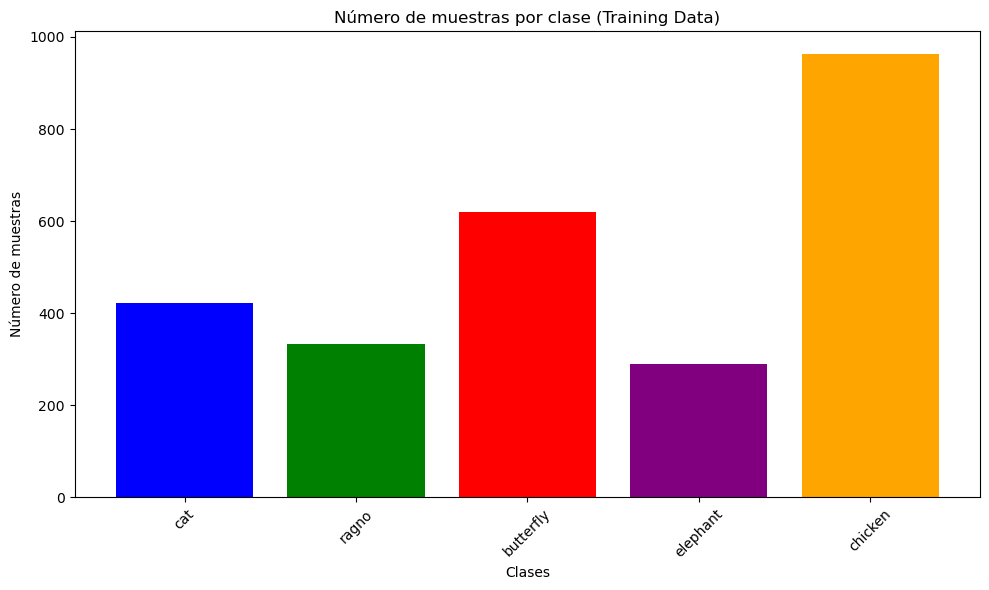

In [15]:
x = np.arange(5)

plt.figure(figsize=(10, 6))
plt.bar(x, val_class_counts, color=colors)

plt.xticks(x, selected_classes, rotation=45)
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.title("Número de muestras por clase (Training Data)")
plt.tight_layout()
plt.show()

## CNN propuesta

En este bloque se nos pide que diseñemos una red neuronal convolucional o que empleemos una arquitectura conocida (entrenada desde cero) para clasificar las imágenes. La segunda opción nos parece más interesante para poder comparar el mismo modelo tras aplicar *Transfer Learning* como veremos posteriormente.

In [16]:
# Verificar dispositivos físicos disponibles
physical_devices = tf.config.list_physical_devices()
print("Dispositivos físicos disponibles:", physical_devices)

# Verificar si hay GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs disponibles:", gpus)
    # Configurar TensorFlow para usar la primera GPU
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
else:
    print("No hay GPUs disponibles.")

Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Definimos nuestro modelo InceptionV3 e imprimimos un resumen del modelo. Cabe destacar como el  parámetro de los pesos es nulo, pues en este apartado, como ya comentamos anteriormente, no se va a importar pesos preentrenados.

In [17]:
model = InceptionV3(weights=None, include_top=True, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=NUM_CLASSES)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

Se definen dos modelos de optimizador: 

In [18]:
adam = Adam(learning_rate=0.001)
sgd  = SGD(learning_rate=0.001, momentum=0.9)

Compilamos el modelo con la función de pérdida `categorical_crossentropy` y diferentes métricas para la evaluación del modelo.

In [19]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

Entrenamos el modelo y los almacenamos en `history`

In [21]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
702/702 [==============================] - 168s 224ms/step - loss: 1.2034 - accuracy: 0.5424 - precision: 0.6576 - recall: 0.3787 - val_loss: 1.7542 - val_accuracy: 0.4675 - val_precision: 0.5614 - val_recall: 0.3883
Epoch 2/20
702/702 [==============================] - 156s 222ms/step - loss: 0.8549 - accuracy: 0.6864 - precision: 0.7614 - recall: 0.5971 - val_loss: 0.7867 - val_accuracy: 0.7027 - val_precision: 0.7657 - val_recall: 0.6395
Epoch 3/20
702/702 [==============================] - 156s 222ms/step - loss: 0.7152 - accuracy: 0.7496 - precision: 0.8061 - recall: 0.6848 - val_loss: 0.7414 - val_accuracy: 0.7309 - val_precision: 0.7953 - val_recall: 0.6597
Epoch 4/20
702/702 [==============================] - 156s 222ms/step - loss: 0.6589 - accuracy: 0.7716 - precision: 0.8207 - recall: 0.7175 - val_loss: 0.8010 - val_accuracy: 0.7164 - val_precision: 0.7862 - val_recall: 0.6566
Epoch 5/20
702/702 [==============================] - 156s 223ms/step - loss: 0.5803 - a

Definimos la función de representación para las diferentes métricas

In [22]:
def plot_training_history(history, metrics, title="Training and Validation Metrics", save_path=None):
    valid_metrics = [metric for metric in metrics if metric in history.history]
    num_metrics = len(valid_metrics)
    rows = (num_metrics + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axs = axs.flatten()

    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axs, valid_metrics):
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue', linestyle='-', marker='o')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color='orange', linestyle='--', marker='x')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training vs. Validation {metric.capitalize()}')
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)

    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [23]:
print("Métricas disponibles en history:")
print(history.history.keys())

Métricas disponibles en history:
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


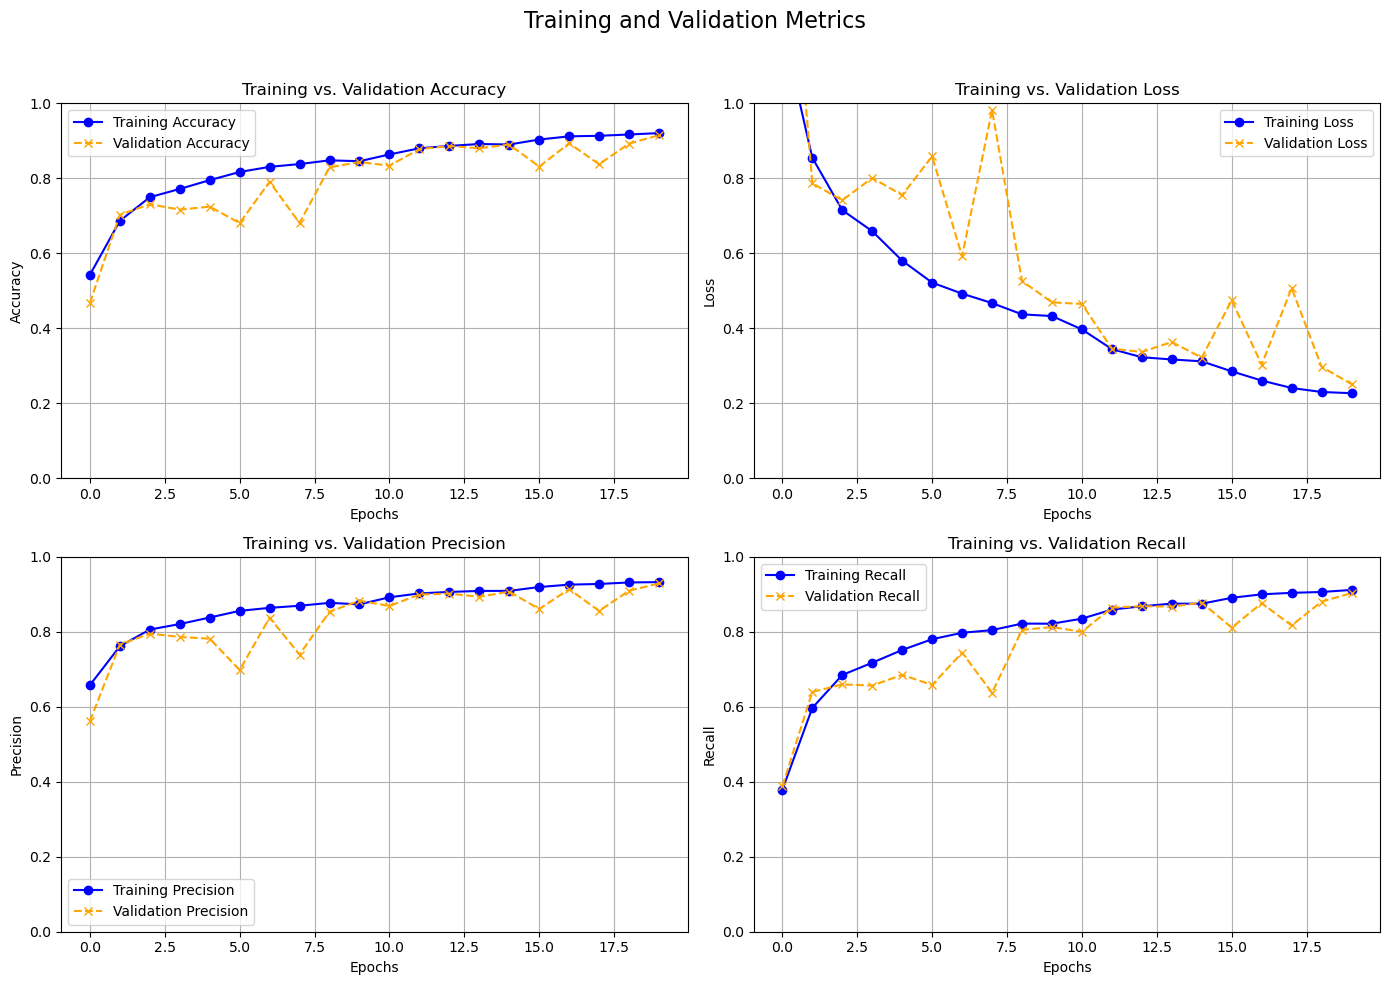

In [24]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
plot_training_history(history, metrics)

In [25]:
y_test = val_ds.classes
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test,y_pred,target_names = selected_classes))

176/176 [==============================] - 12s 63ms/step
              precision    recall  f1-score   support

         cat       0.86      0.89      0.87       422
       ragno       0.92      0.84      0.88       333
   butterfly       0.91      0.95      0.93       619
    elephant       0.95      0.85      0.90       289
     chicken       0.93      0.95      0.94       964

    accuracy                           0.92      2627
   macro avg       0.91      0.90      0.90      2627
weighted avg       0.92      0.92      0.91      2627



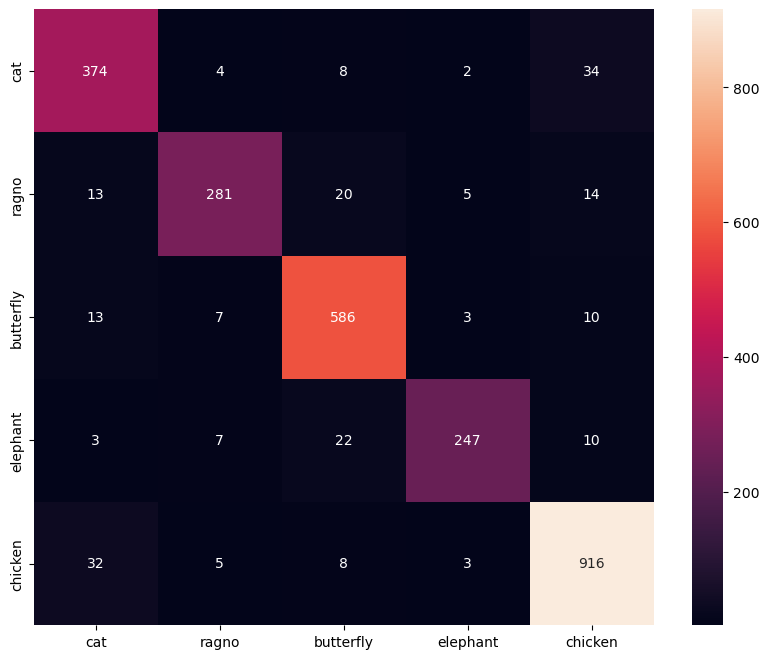

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=selected_classes,yticklabels=selected_classes)
plt.show()

## Transfer Learning

Para hacer *Transfer Learning* y clasificar vamos a seleccionar la red neuronal convolucional Inception. En el siguiente enlace tenemos una lista con diferentes modelos disponibles en la biblioteca de keras (https://keras.io/api/applications/). Como nos tenemos que limitar a emplear una de las que hemos visto en la asignatura, empleamos ese modelo dado a las buenas características que nos ofrece. De no ser así, hubiésemos empleado el modelo de EfficientBX.

Importamos nuestro modelo con los pesos preentrenados de `imagenet`. Además, congelamos todas las capas de nuestro modelo para que no se acualicen durante el entrenamiento.

In [27]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = False

Añadimos capas adicionales a nuestro modelo base ya preentrenado. A la salida del modelo base aplicamos una capa `averagePooling`, añadimos una capa densa con 512 neuronas y función de activación relu. A la salida, una capa densa con 5 neuronas y una función de activación softmax para realizar la clasificación de las 5 clases de animales. Definimos así, un nuevo modelo `tl_model` a partir de las entradas del modelo base y las nuevas salidas de predicciones.

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation='relu')(x)  
predictions = Dense(5, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=predictions)

Compilamos nuestro modelo con el optimizador `Adam` y un *learning rate* de 0.001, una función de périda de `categorical_crossentropy` y diferentes métricas

In [29]:
tl_model.compile(
    loss="categorical_crossentropy",       
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    metrics=["accuracy", Precision(), Recall()]  
)

Veamos nuestro modelo

In [30]:
tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                             

En este código se configuran los callbacks para el entrenamiento de un modelo:

- EarlyStopping: Detiene el entrenamiento si la pérdida de validación no mejora después de 4 épocas.

- ModelCheckpoint: Guarda el mejor modelo basado en la pérdida de validación.

- ReduceLROnPlateau: Reduce la tasa de aprendizaje si la pérdida de validación no mejora después de 5 épocas.

- callback: Lista que agrupa estos callbacks.

In [31]:
early_stopping=EarlyStopping(monitor='val_loss',patience=4,verbose=1, restore_best_weights=True)
checkpoints=ModelCheckpoint('tl_inception3V.keras', monitor='val_loss', save_best_only=True,verbose=1)
reduceonplateau=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
callback=[early_stopping,reduceonplateau,checkpoints]

Entrenamos el modelo con 7 *epoch* y un tamaño de *batch* de 64.

In [32]:
tl_history =tl_model.fit(train_ds,
                   epochs=7,
                   validation_data=val_ds,
                   callbacks=callback,
                   batch_size=64)

Epoch 1/7
702/702 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9696 - precision_1: 0.9754 - recall_1: 0.9670
Epoch 1: val_loss improved from inf to 0.05412, saving model to tl_inception3V.keras
702/702 [==============================] - 65s 87ms/step - loss: 0.1049 - accuracy: 0.9696 - precision_1: 0.9754 - recall_1: 0.9670 - val_loss: 0.0541 - val_accuracy: 0.9825 - val_precision_1: 0.9862 - val_recall_1: 0.9802 - lr: 0.0010
Epoch 2/7
702/702 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9855 - precision_1: 0.9869 - recall_1: 0.9842
Epoch 2: val_loss improved from 0.05412 to 0.04516, saving model to tl_inception3V.keras
702/702 [==============================] - 59s 84ms/step - loss: 0.0425 - accuracy: 0.9855 - precision_1: 0.9869 - recall_1: 0.9842 - val_loss: 0.0452 - val_accuracy: 0.9852 - val_precision_1: 0.9870 - val_recall_1: 0.9844 - lr: 0.0010
Epoch 3/7
702/702 [==============================] - ETA: 0s - loss: 0.0412 - accu

In [33]:
print("Métricas disponibles en tl_history:")
print(tl_history.history.keys())

Métricas disponibles en tl_history:
dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'lr'])


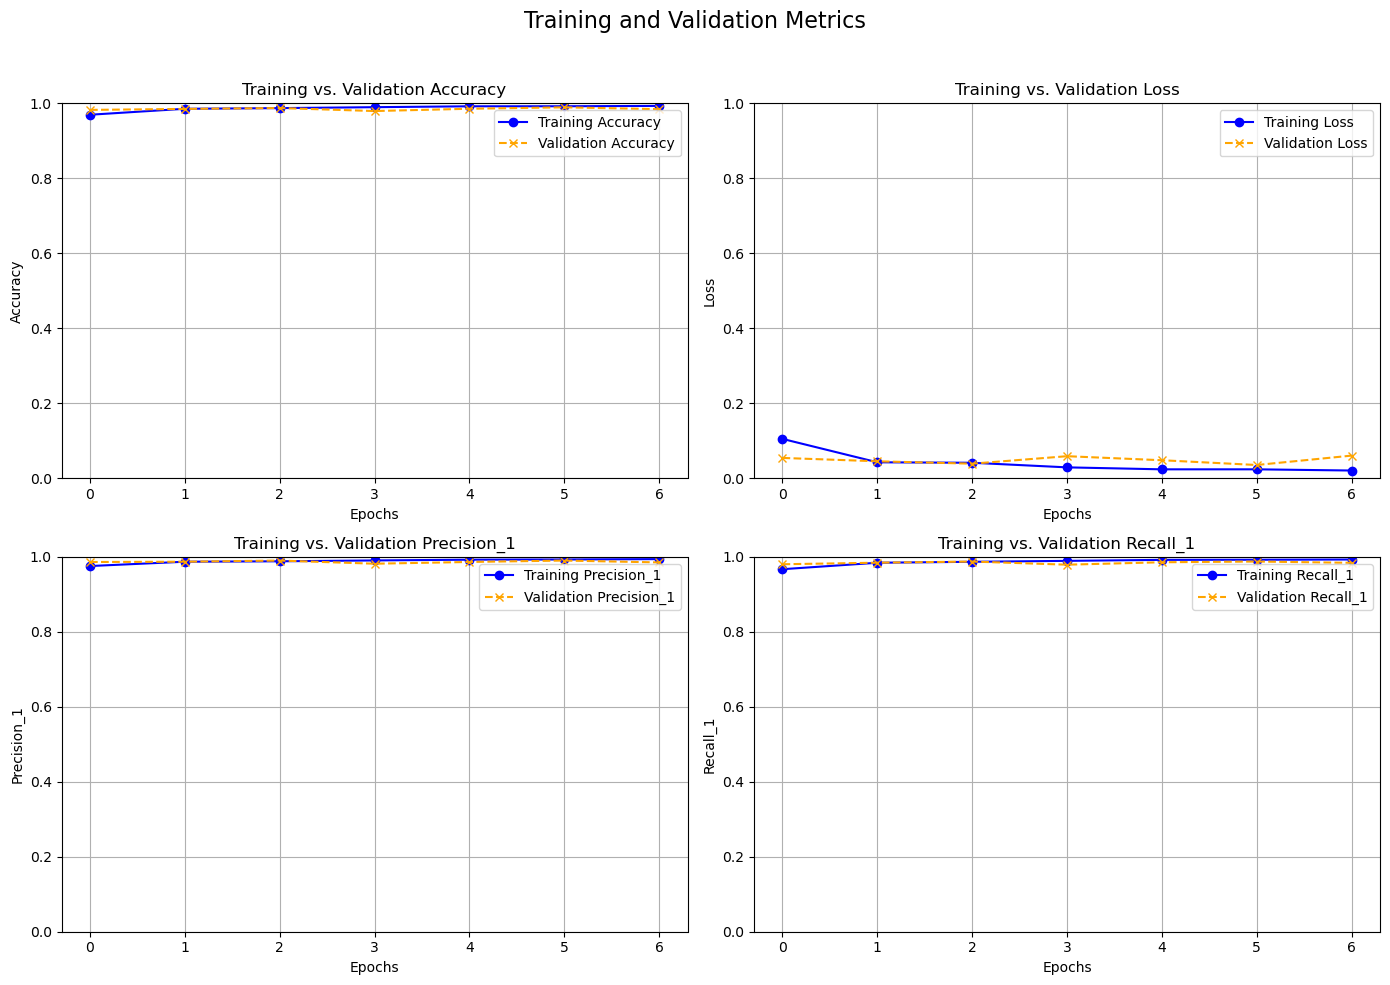

In [34]:
metrics = ['accuracy', 'loss', 'precision_1', 'recall_1']
plot_training_history(tl_history, metrics)

Cargamos el modelo que guardamos con anterioridad y realizamos las predicciones. Además, imprimimos un reporte de las clasificaciones.

In [36]:
best_tl_model = load_model('tl_inception3V.keras')

y_test = val_ds.classes
y_pred_tl = best_tl_model.predict(val_ds)
y_pred_tl = np.argmax(y_pred_tl, axis=1)

print(classification_report(y_test, y_pred_tl, target_names=selected_classes))

176/176 [==============================] - 12s 63ms/step
              precision    recall  f1-score   support

         cat       0.99      0.96      0.97       422
       ragno       0.99      1.00      0.99       333
   butterfly       1.00      1.00      1.00       619
    elephant       0.99      0.99      0.99       289
     chicken       0.99      0.99      0.99       964

    accuracy                           0.99      2627
   macro avg       0.99      0.99      0.99      2627
weighted avg       0.99      0.99      0.99      2627



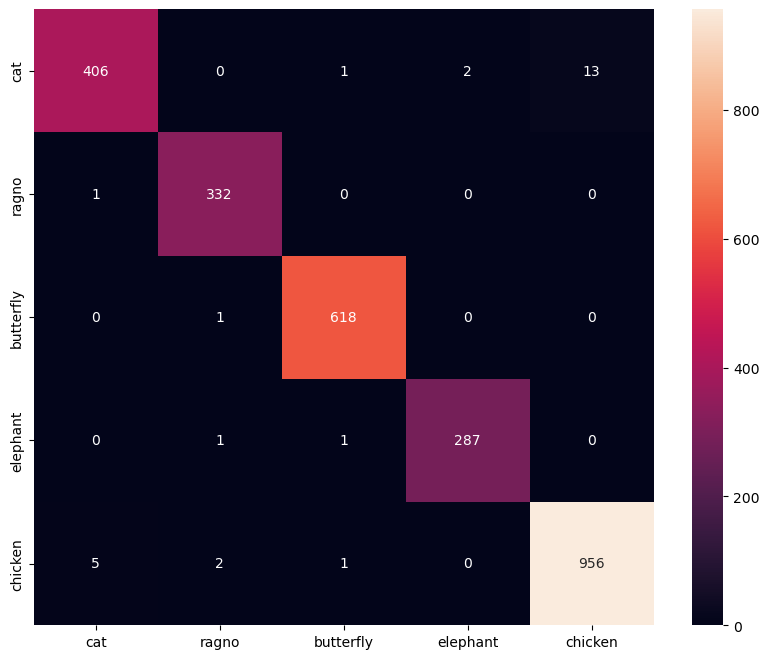

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred_tl),annot=True,fmt='.3g',xticklabels=selected_classes,yticklabels=selected_classes)
plt.show()